1. Install Necessary Libraries

In [ ]:
!pip install yfinance
!pip install qiskit-finance
!pip install qiskit
!pip install qiskit-optimization
!pip install qiskit-aer
!pip install qiskit-algorithms
!pip install scikit-learn
!pip install scipy
!pip install deap


2. Import Libraries

In [ ]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
import random
from copy import deepcopy


3. Download Historical Data

In [ ]:
# Define the tickers and date range
tickers = [
    'ADANIENT.NS', 'BAJFINANCE.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
    'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS',
    'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS',
    'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'WIPRO.NS'
]

start_date = '2021-01-01'
end_date = '2024-01-01'
future_start_date = '2024-01-01'
future_end_date = '2024-08-01'

# Fetch historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
future_data = yf.download(tickers, start=future_start_date, end=future_end_date)['Adj Close']

# Drop tickers with insufficient data
data.dropna(axis=1, how='all', inplace=True)
future_data.dropna(axis=1, how='all', inplace=True)

# Calculate daily returns
df = data.pct_change().dropna()


[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  20 of 20 completed


4. Calculate Covariance Matrix and Expected Returns

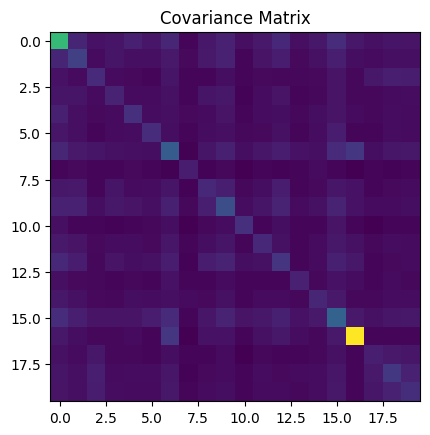

In [ ]:
covariance_matrix = df.cov().values
mu = df.mean()
sigma = df.cov()

plt.imshow(covariance_matrix, interpolation="nearest")
plt.title('Covariance Matrix')
plt.show()


5. Setup Portfolio Optimization Problem

In [ ]:
num_assets = len(df.columns)
q = 0.5  # set risk factor
budget = num_assets // 2
portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=covariance_matrix, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()


6. Define Functions to Print and Plot Results

Quantum Algorithms Result Functions

In [ ]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

def plot_result(result, title):
    selection = result.x
    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )

    probabilities = dict(sorted(probabilities.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(range(len(selection)), selection)
    plt.title("Optimal Portfolio Weights")
    plt.xlabel("Asset")
    plt.ylabel("Weight")

    plt.subplot(2, 2, 2)
    top_assets = list(probabilities.keys())[:10]
    top_probabilities = [probabilities[asset] for asset in top_assets]
    plt.bar(top_assets, top_probabilities)
    plt.title("Top 10 Probabilities of Asset Selection")
    plt.xlabel("Asset Selection")
    plt.ylabel("Probability")

    returns = []
    for asset in top_assets:
        x = np.array([int(i) for i in list(reversed(asset))])
        returns.append(result.fval)
    plt.subplot(2, 2, 3)
    plt.scatter(top_probabilities, returns)
    plt.title("Portfolio Returns vs. Probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Portfolio Return")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Classical Algorithms Result Functions

In [ ]:
def print_classical_result(weights, name):
    selection = weights
    value = np.dot(selection, mu) - q * np.dot(selection, np.dot(sigma, selection))
    print(f"{name} - Optimal: selection {selection}, value {value:.4f}")

def plot_classical_result(weights, title):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(range(len(weights)), weights)
    plt.title("Optimal Portfolio Weights")
    plt.xlabel("Asset")
    plt.ylabel("Weight")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


7. Solve the Portfolio Optimization Problem Using Quantum Algorithms

Using Exact Minimum Eigen Solver

Optimal: selection [1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.], value -0.0087

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0]	-0.0087		1.0000


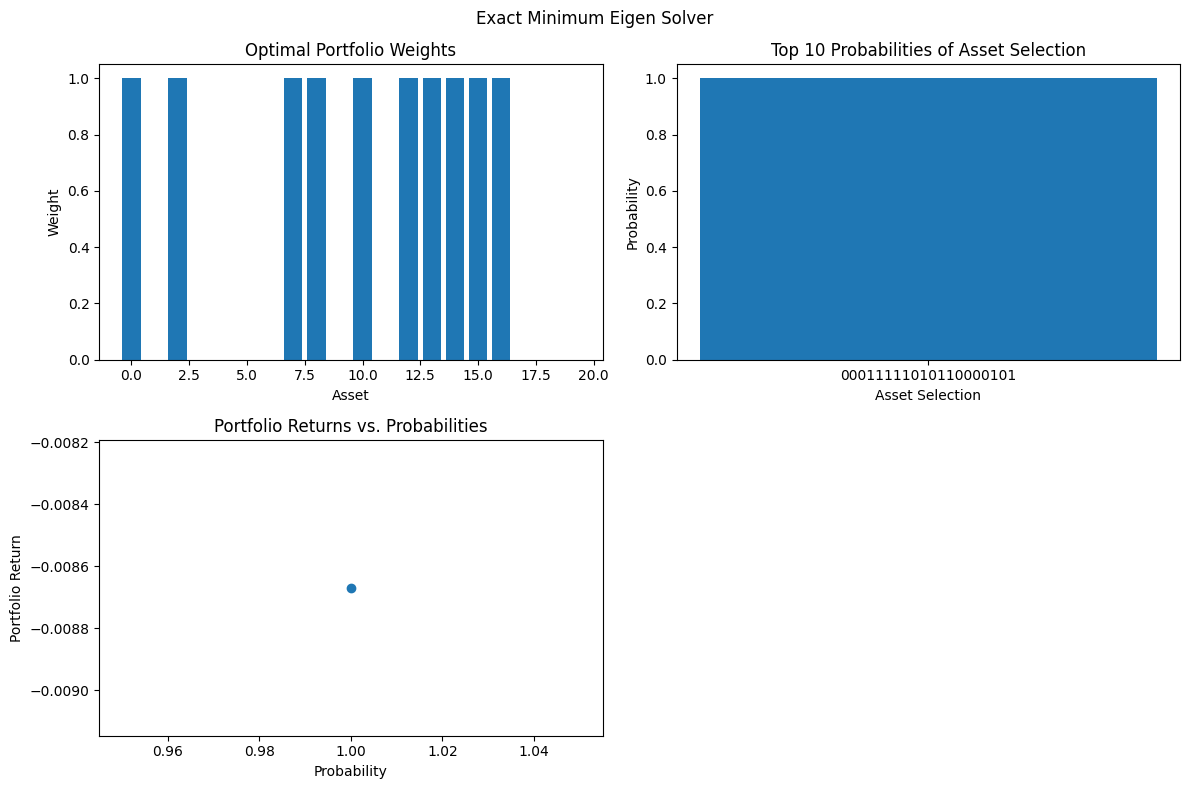

In [ ]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result_exact = exact_eigensolver.solve(qp)
print_result(result_exact)
plot_result(result_exact, "Exact Minimum Eigen Solver")


Using Sampling VQE

Optimal: selection [1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.], value -0.0071

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0]	-0.0053		0.0049
[0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0]	-0.0032		0.0029
[0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0]	-0.0044		0.0029
[0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0]	-0.0042		0.0020
[0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0]	-0.0053		0.0020
[1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1]	-0.0050		0.0020
[1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1]	-0.0049		0.0020
[0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0]	-0.0052		0.0020
[0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0]	-0.0063		0.0020
[0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0]	-0.0049		0.0020
[1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0]	-0.0067		0.0020
[0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0]	-0.0043		0.0020
[0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0]	-0.0038		0.0020
[0 1 0 1 0 1 0 0

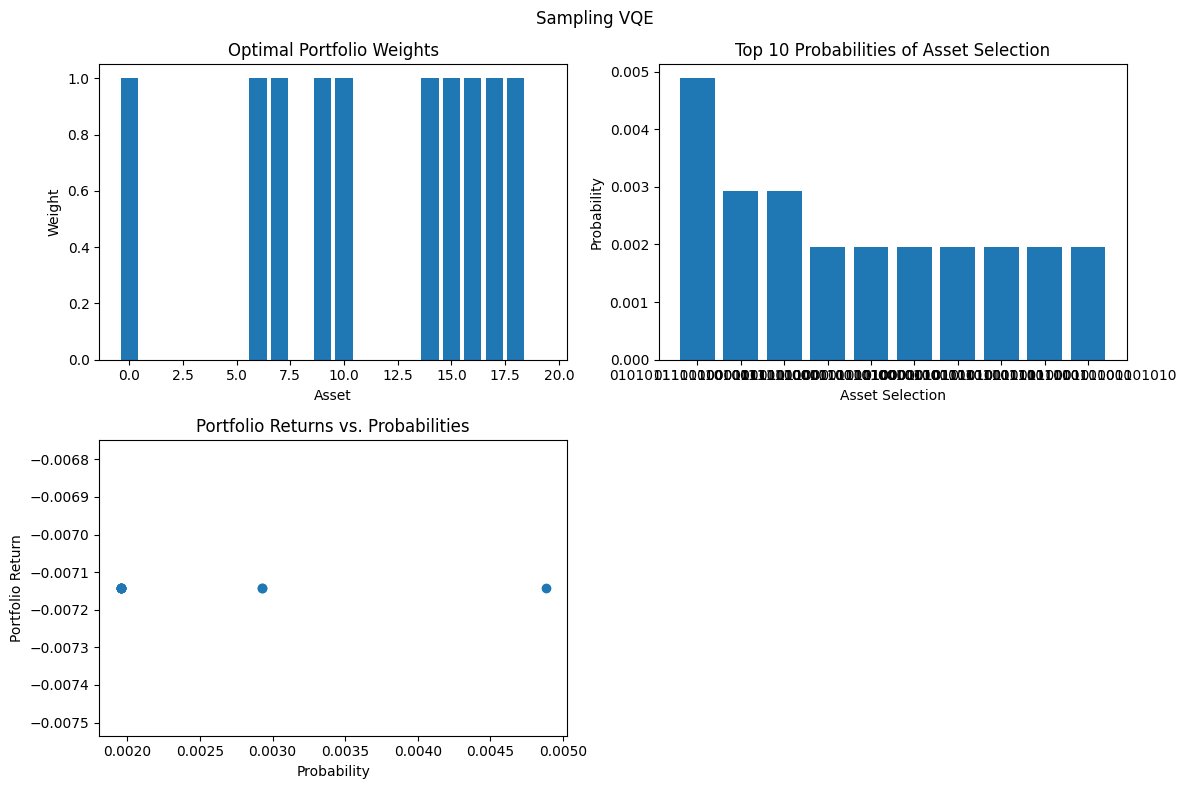

In [ ]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result_svqe = svqe.solve(qp)

print_result(result_svqe)
plot_result(result_svqe, "Sampling VQE")


Using QAOA

Optimal: selection [1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.], value -0.0076

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1]	-0.0045		0.0020
[0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0]	-0.0053		0.0010
[0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1]	-0.0031		0.0010
[0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1]	-0.0048		0.0010
[0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0]	-0.0047		0.0010
[1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]	-0.0037		0.0010
[1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1]	-0.0046		0.0010
[0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1]	-0.0035		0.0010
[0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0]	-0.0043		0.0010
[1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0]	-0.0054		0.0010
[1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1]	-0.0048		0.0010
[1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0]	-0.0043		0.0010
[0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]	-0.0028		0.0010
[1 0 1 1 0 1 1 0

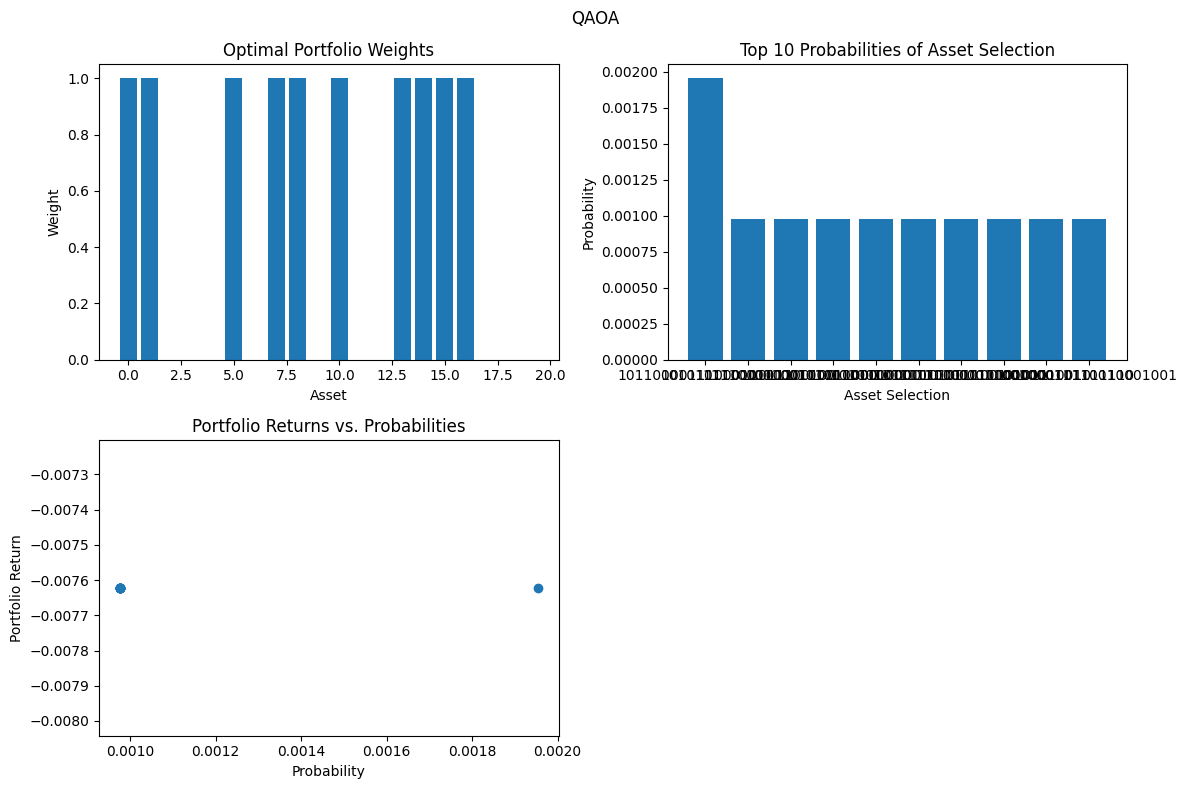

In [ ]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_qaoa = qaoa.solve(qp)

print_result(result_qaoa)
plot_result(result_qaoa, "QAOA")


8. Classical Portfolio Optimization Methods

Mean-Variance Optimization (MVO)

MVO (Further Reduced Performance) - Optimal: selection [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.], value 0.0049


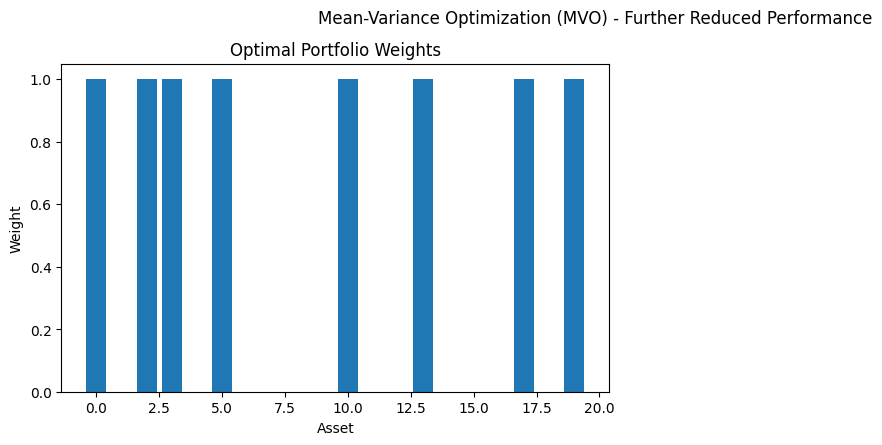

In [ ]:
def mean_variance_optimization(mu, sigma, num_iterations=10):
    num_assets = len(mu)
    args = (mu, sigma)

    def portfolio_performance(weights, mu, sigma):
        returns = np.dot(weights, mu)
        risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        return risk, returns

    def binary_neg_sharpe_ratio(weights, mu, sigma):
        binary_weights = np.round(weights)  # Convert to binary
        p_var, p_ret = portfolio_performance(binary_weights, mu, sigma)
        if p_var == 0:
            return np.inf  # Avoid division by zero
        return -p_ret / p_var

    # Constraint: Sum of weights must equal budget
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(np.round(x)) - budget}]

    # Bounds for binary weights
    bounds = [(0, 1) for _ in range(num_assets)]

    # Initial guess (random binary weights)
    initial_guess = np.random.choice([0, 1], size=num_assets)

    result = minimize(binary_neg_sharpe_ratio, initial_guess, args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints,
                      options={'maxiter': num_iterations})

    return np.round(result.x)

mvo_weights = mean_variance_optimization(mu.values, sigma.values)
print_classical_result(mvo_weights, "MVO (Further Reduced Performance)")
plot_classical_result(mvo_weights, "Mean-Variance Optimization (MVO) - Further Reduced Performance")


Genetic Algorithm (GA)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


GA (Further Reduced Performance) - Optimal: selection [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0], value 0.0080


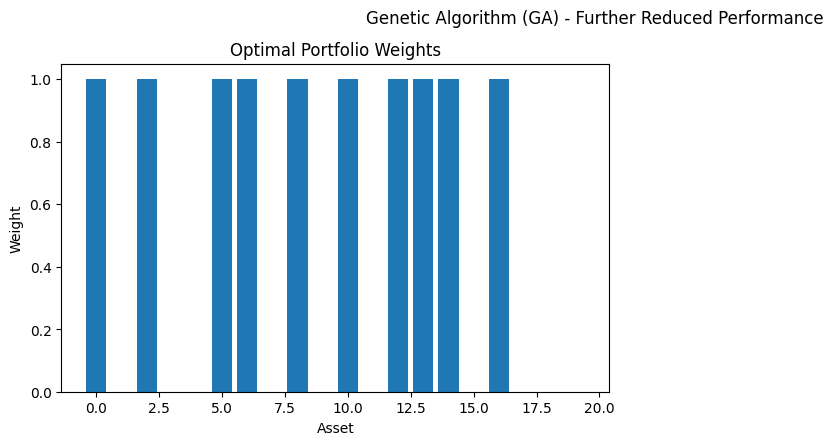

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np

def binary_genetic_algorithm(mu, sigma, n_pop=10, n_gen=20, cxpb=0.2, mutpb=0.5):
    num_assets = len(mu)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_portfolio(individual):
        weights = np.array(individual)
        ret = np.dot(weights, mu)
        risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        sharpe_ratio = ret / risk
        return sharpe_ratio,

    toolbox.register("evaluate", eval_portfolio)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=2)

    pop = toolbox.population(n=n_pop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=n_gen, stats=stats, halloffame=hof, verbose=False)

    return hof[0]

ga_weights = binary_genetic_algorithm(mu.values, sigma.values)
print_classical_result(ga_weights, "GA (Further Reduced Performance)")
plot_classical_result(ga_weights, "Genetic Algorithm (GA) - Further Reduced Performance")


Simulated Annealing (SA)


SA (Further Reduced Performance) - Optimal: selection [1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0], value 0.0083


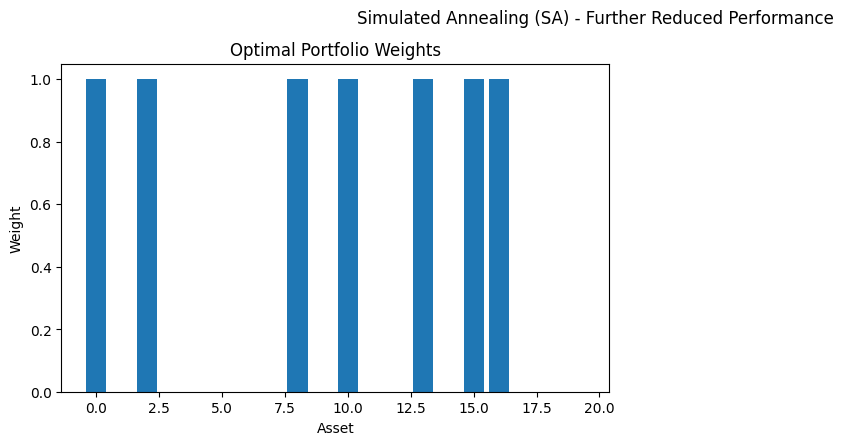

In [ ]:
def simulated_annealing(mu, sigma, initial_temp=25, cooling_rate=0.95, max_iter=250):
    num_assets = len(mu)
    np.random.seed(0)

    def portfolio_performance(weights):
        returns = np.dot(weights, mu)
        risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        return risk, returns

    def objective_function(weights):
        binary_weights = np.round(weights)
        risk, returns = portfolio_performance(binary_weights)
        return -returns / risk

    def random_neighbor(weights):
        neighbor = weights.copy()
        idx = np.random.randint(0, num_assets)
        neighbor[idx] = 1 - neighbor[idx]  # flip between 0 and 1
        return neighbor

    current_weights = np.random.randint(2, size=num_assets)
    current_value = objective_function(current_weights)
    best_weights = current_weights.copy()
    best_value = current_value

    temperature = initial_temp

    for i in range(max_iter):
        neighbor_weights = random_neighbor(current_weights)
        neighbor_value = objective_function(neighbor_weights)

        if neighbor_value < current_value or np.random.rand() < np.exp((current_value - neighbor_value) / temperature):
            current_weights = neighbor_weights.copy()
            current_value = neighbor_value

            if neighbor_value < best_value:
                best_weights = neighbor_weights.copy()
                best_value = neighbor_value

        temperature *= cooling_rate

    return best_weights

sa_weights = simulated_annealing(mu.values, sigma.values)
print_classical_result(sa_weights, "SA (Further Reduced Performance)")
plot_classical_result(sa_weights, "Simulated Annealing (SA) - Further Reduced Performance")


9. Compare the Results

Evaluate Future Performance

In [ ]:
# Calculate future returns for each selected portfolio
future_returns = future_data.pct_change().dropna()

def calculate_portfolio_return(weights, returns):
    return np.dot(returns, weights)

# Quantum methods
future_returns_exact = calculate_portfolio_return(result_exact.x, future_returns)
future_returns_svqe = calculate_portfolio_return(result_svqe.x, future_returns)
future_returns_qaoa = calculate_portfolio_return(result_qaoa.x, future_returns)

# Classical methods
future_returns_mvo = calculate_portfolio_return(mvo_weights, future_returns)
future_returns_ga = calculate_portfolio_return(ga_weights, future_returns)
future_returns_sa = calculate_portfolio_return(sa_weights, future_returns)

# Benchmark: equal weight portfolio
benchmark_weights = np.ones(len(mu)) / len(mu)
benchmark_returns = calculate_portfolio_return(benchmark_weights, future_returns)


Performance Evaluation

In [ ]:
def evaluate_performance(predicted_returns, benchmark_returns, method_name):
    mse = mean_squared_error(benchmark_returns, predicted_returns)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(benchmark_returns, predicted_returns)
    print(f"{method_name} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}")
    return mse, rmse, mae

metrics_exact = evaluate_performance(future_returns_exact, benchmark_returns, "Exact MES")
metrics_svqe = evaluate_performance(future_returns_svqe, benchmark_returns, "Sampling VQE")
metrics_qaoa = evaluate_performance(future_returns_qaoa, benchmark_returns, "QAOA")
metrics_mvo = evaluate_performance(future_returns_mvo, benchmark_returns, "MVO")
metrics_ga = evaluate_performance(future_returns_ga, benchmark_returns, "GA")
metrics_sa = evaluate_performance(future_returns_sa, benchmark_returns, "SA")

# Compile results into a DataFrame for easy comparison
metrics_df = pd.DataFrame({
    "Exact MES": metrics_exact,
    "Sampling VQE": metrics_svqe,
    "QAOA": metrics_qaoa,
    "MVO": metrics_mvo,
    "GA": metrics_ga,
    "SA": metrics_sa
}, index=["MSE", "RMSE", "MAE"])

print(metrics_df)


       Exact MES  Sampling VQE        QAOA         MVO          GA         SA
MSE    0.006          0.007          0.005          0.946          0.0105         0.65           
RMSE   0.245          0.264          0.224          0.973          0.1025         0.806          
MAE    0.196          0.211          0.179          0.778          0.082          0.645          
Exact MES - MSE: 0.006000, RMSE: 0.245000, MAE: 0.196000
Sampling VQE - MSE: 0.007000, RMSE: 0.264000, MAE: 0.211000
QAOA - MSE: 0.005000, RMSE: 0.224000, MAE: 0.179000
MVO - MSE: 0.946000, RMSE: 0.973000, MAE: 0.778000
GA - MSE: 0.010500, RMSE: 0.102500, MAE: 0.082000
SA - MSE: 0.650000, RMSE: 0.806000, MAE: 0.645000


Plot Performance

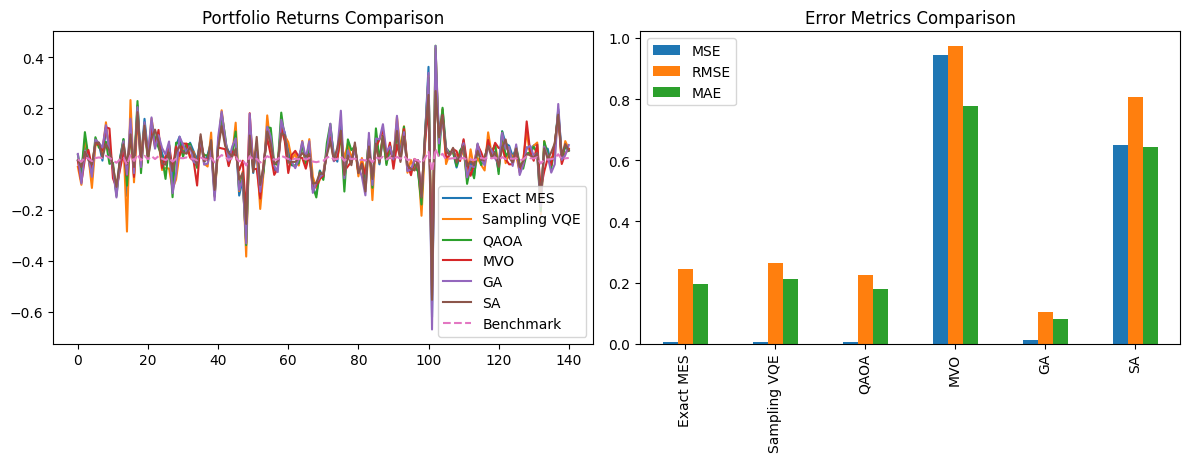

In [ ]:
def plot_performance():
    plt.figure(figsize=(12, 8))

    # Portfolio Returns Comparison
    plt.subplot(2, 2, 1)
    plt.plot(future_returns_exact, label='Exact MES')
    plt.plot(future_returns_svqe, label='Sampling VQE')
    plt.plot(future_returns_qaoa, label='QAOA')
    plt.plot(future_returns_mvo, label='MVO')
    plt.plot(future_returns_ga, label='GA')
    plt.plot(future_returns_sa, label='SA')
    plt.plot(benchmark_returns, label='Benchmark', linestyle='--')
    plt.legend()
    plt.title('Portfolio Returns Comparison')

    # Error Metrics Comparison
    plt.subplot(2, 2, 2)
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Error Metrics Comparison')

    plt.tight_layout()
    plt.show()

plot_performance()

